# Stock Price Prediction (LSTM Model)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from keras.layers import Dense, LSTM, Dropout, Input
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam, Adamax, Nadam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

### Data Download........

In [2]:
df = yf.download('^BSESN', "2019-01-01", datetime.today().strftime('%Y-%m-%d')).reset_index()
df = df.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Close
0,35891.519531
1,35513.710938
2,35695.101562
3,35850.160156
4,35980.929688


### Calculation and plotting of Moving Average 

In [3]:
ma100 = df['Close'].rolling(window=100).mean().dropna()
ma200 = df['Close'].rolling(window=200).mean().dropna()

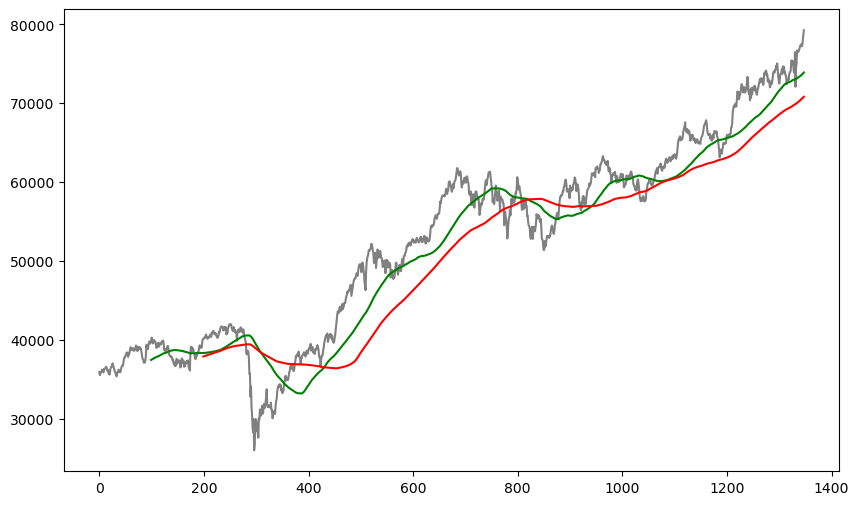

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df["Close"], color="grey")
plt.plot(ma100, color = "green")
plt.plot(ma200, color = "red")

plt.show()

### Calculation of Exponential Moving Average

In [5]:
ema100 = df['Close'].ewm(span=100, adjust=False).mean().dropna()
ema200 = df['Close'].ewm(span=200, adjust=False).mean().dropna()

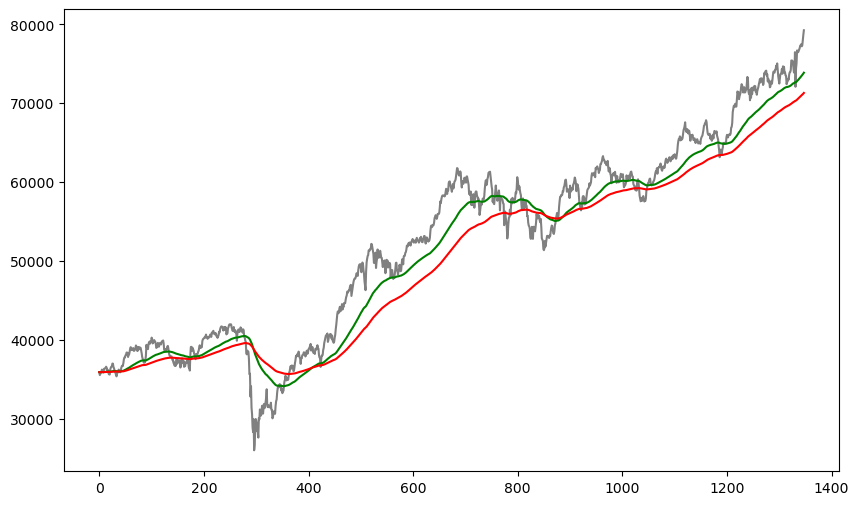

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df["Close"], color="grey")
plt.plot(ema100, color = "green")
plt.plot(ema200, color = "red")

plt.show()

### Data Preprocessing and Handling

In [7]:
df.shape

(1348, 1)

In [8]:
data_training = df['Close'][:int(len(df) * 0.70)]
data_testing = df['Close'][int(len(df) * 0.70):]

print(data_training.shape)
print(data_testing.shape)

(943,)
(405,)


In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_training.values.reshape(-1, 1))

In [10]:
x_train = []
y_train = []

for i in range (100, len(scaled_data)):
    x_train.append(scaled_data[i-100:i])
    y_train.append(scaled_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_training], ignore_index=True)
final_df_scaled = scaler.fit_transform(final_df.values.reshape(-1, 1))

In [11]:
x_train.shape

(843, 100, 1)

In [12]:
y_train.shape

(843,)

In [13]:
final_df_scaled.shape

(1043, 1)

In [14]:
x_test = []
y_test = []

for i in range(100, len(final_df_scaled)):
    x_test.append(final_df_scaled[i-100:i])
    y_test.append(final_df_scaled[i,0])
    
x_test, y_test = np.array(x_test), np.array(y_test)



In [15]:
x_test.shape

(943, 100, 1)

In [16]:
y_test.shape

(943,)

## Machine Learning Model

### Model Building

In [17]:
# Function to build the model
def build_model(units):
    model = Sequential()
    model.add(Input(shape=(100,1)))
    model.add(LSTM(units=units, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=units, activation='relu', return_sequences=True))  # Ensure this layer also returns sequences
    model.add(Dropout(0.4))
    model.add(LSTM(units=units, activation='relu'))  # The last LSTM layer should not return sequences
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='linear'))
    return model

In [18]:
model_summary = build_model(90)
model_summary.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 90)        │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 90)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 90)        │        65,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 90)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 90)        │        65,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 90)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 90)             │        65,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,691 (893.32 KB)

 Trainable params: 228,691 (893.32 KB)

 Non-trainable params: 0 (0.00 B)

### List of optimizer classes and loss functions to try out

In [19]:
# Define optimizers and loss functions
optimizer_classes = {
    'Adam': Adam,
    'Adamax': Adamax,
    'Nadam': Nadam
}

loss_functions = {
    'MeanSquaredError': 'mean_squared_error',
    'MeanAbsoluteError': 'mean_absolute_error'
}


### Function to iterate over the list of optimizer classes and loss functions to find the best one

In [20]:
# Function to train the model with different optimizers and loss functions
def train_and_evaluate(optimizer_name, optimizer_class, loss_name, loss_fn):
    model = build_model(100)
    optimizer = optimizer_class()  # Create a new optimizer instance
    model.compile(optimizer=optimizer, loss=loss_fn)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
                        callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    y_pred = model.predict(x_test)
    y_pred_inverse = scaler.inverse_transform(y_pred)
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    
    return {
        'optimizer': optimizer_name,
        'loss_function': loss_name,
        'history': history,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }

# Dictionary to store the results
results = []
histories = {}

# Train and evaluate models with each optimizer and loss function combination
for opt_name, optimizer_class in optimizer_classes.items():
    for loss_name, loss_fn in loss_functions.items():
        print(f"Training with {opt_name} optimizer and {loss_name} loss function...")
        result = train_and_evaluate(opt_name, optimizer_class, loss_name, loss_fn)
        results.append(result)
        histories[f"{opt_name}-{loss_name}"] = result['history']
        print(f"Training with {opt_name} and {loss_name} completed.")

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

Training with Adam optimizer and MeanSquaredError loss function...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Training with Adam and MeanSquaredError completed.
Training with Adam optimizer and MeanAbsoluteError loss function...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Training with Adam and MeanAbsoluteError completed.
Training with Adamax optimizer and MeanSquaredError loss function...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Training with Adamax and MeanSquaredError completed.
Training with Adamax optimizer and MeanAbsoluteError loss function...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Training with Adamax and MeanAbsoluteError completed.
Training with Nadam optimizer and MeanSquaredError loss function...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Training with Nadam and MeanSquaredError completed.
Training with Nadam optimizer and MeanAbsoluteError loss function...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Training with Nadam and MeanAbsoluteError completed.
  optimizer      loss_function  \


### Plotting the best combination of optimizer and loss function

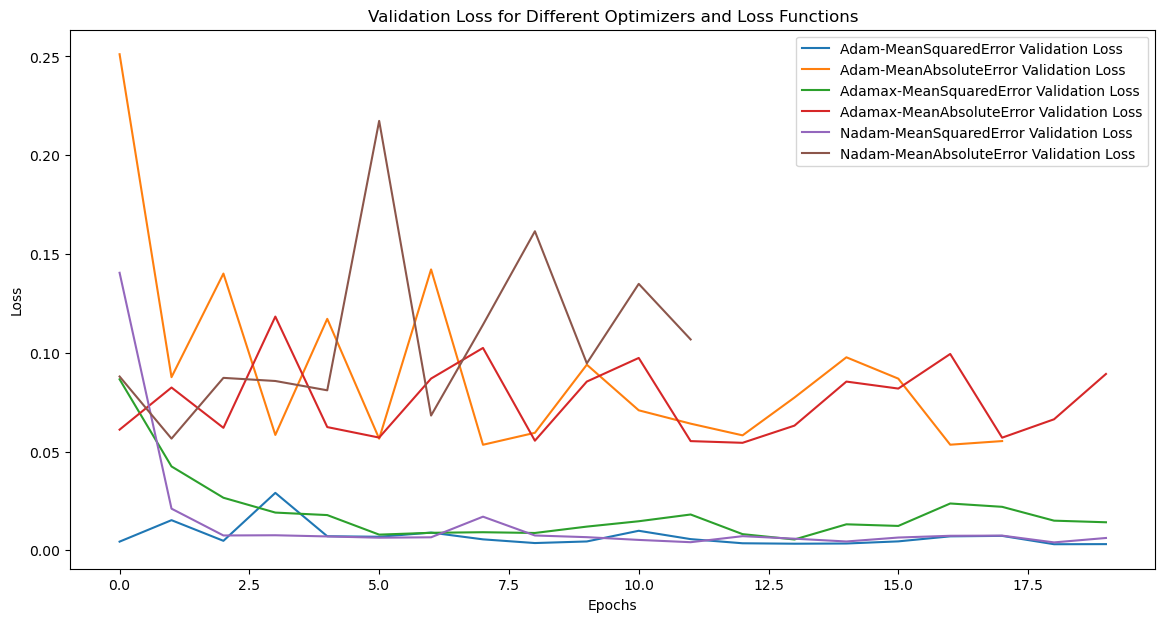

Best Model: Optimizer - Adam, Loss Function - MeanSquaredError
Mean Squared Error: 6929878.63450917
Mean Absolute Error: 1398.0458435511664
R2 Score: 0.9206916804716726


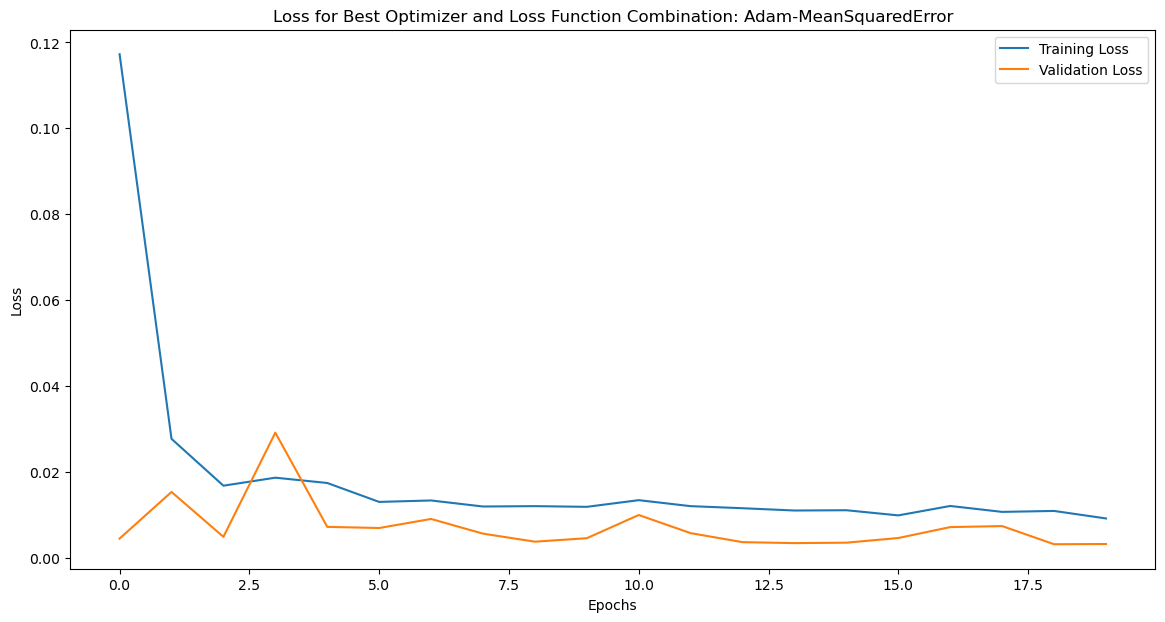

In [21]:
# Plot the training and validation loss for each optimizer-loss function combination
plt.figure(figsize=(14, 7))
for combo, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{combo} Validation Loss')

plt.title('Validation Loss for Different Optimizers and Loss Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Find the best model based on the lowest MSE
best_model = results_df.loc[results_df['mse'].idxmin()]

print(f"Best Model: Optimizer - {best_model['optimizer']}, Loss Function - {best_model['loss_function']}")
print(f"Mean Squared Error: {best_model['mse']}")
print(f"Mean Absolute Error: {best_model['mae']}")
print(f"R2 Score: {best_model['r2']}")

# Plot training and validation loss for the best model
best_combo = f"{best_model['optimizer']}-{best_model['loss_function']}"
best_history = histories[best_combo]

plt.figure(figsize=(14, 7))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss for Best Optimizer and Loss Function Combination: {best_combo}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Finding the optimal number of units for model building

In [22]:
# Define the range of units
units_range = range(50, 201, 10)

# Function to train the model with different units
def train_with_units(units, optimizer_class, loss_fn):
    model = build_model(units)
    optimizer = optimizer_class()  # Create a new optimizer instance
    model.compile(optimizer=optimizer, loss=loss_fn)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
                        callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    y_pred = model.predict(x_test)
    y_pred_inverse = scaler.inverse_transform(y_pred)
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    
    return {
        'units': units,
        'history': history,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }

# Dictionary to store the results for units search
unit_results = []
unit_histories = {}

# Train and evaluate models with each number of units
for units in units_range:
    print(f"Training with {units} units...")
    result = train_with_units(units, optimizer_classes[best_model['optimizer']], loss_functions[best_model['loss_function']])
    unit_results.append(result)
    unit_histories[units] = result['history']
    print(f"Training with {units} units completed.")

# Convert results to DataFrame for easy comparison
unit_results_df = pd.DataFrame(unit_results)

# Display the results
print(unit_results_df)


Training with 50 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Training with 50 units completed.
Training with 60 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Training with 60 units completed.
Training with 70 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Training with 70 units completed.
Training with 80 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
Training with 80 units completed.
Training with 90 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Training with 90 units completed.
Training with 100 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Training with 100 units completed.
Training with 110 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Training with 110 units completed.
Training with 120 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Training with 120 units completed.
Training with 130 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Training with 130 units completed.
Training with 140 units...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Training with 140 units c

### Calculating and plotting the optimal number of units for the model

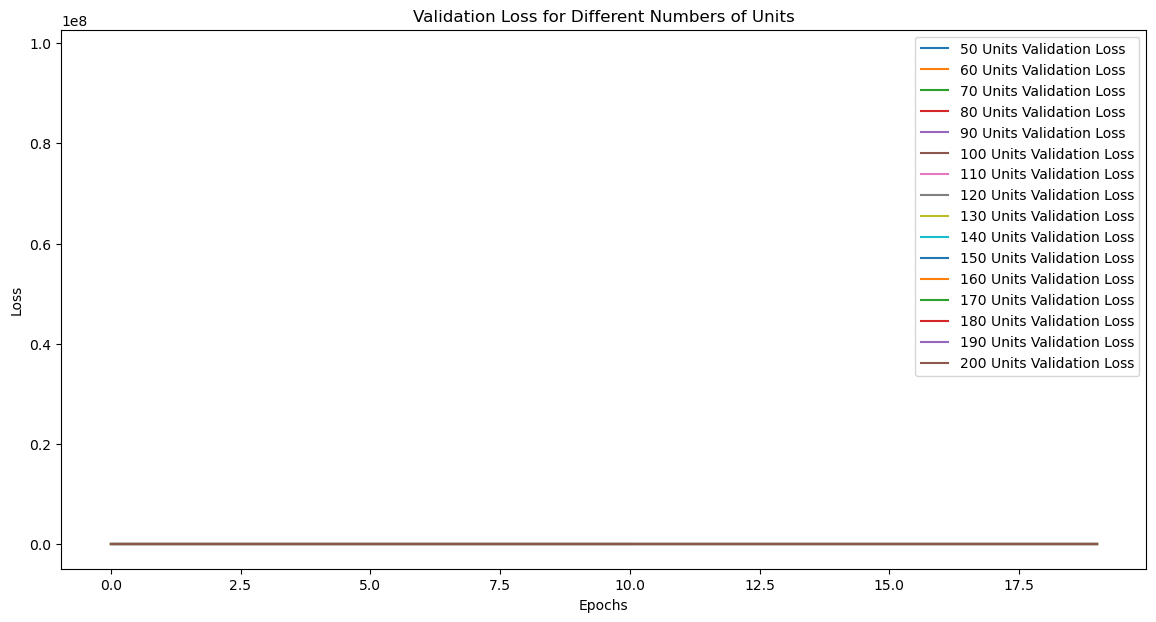

Best Model: Units - 200
Mean Squared Error: 5866768.485216786
Mean Absolute Error: 1351.9125401809385
R2 Score: 0.9328583407929699


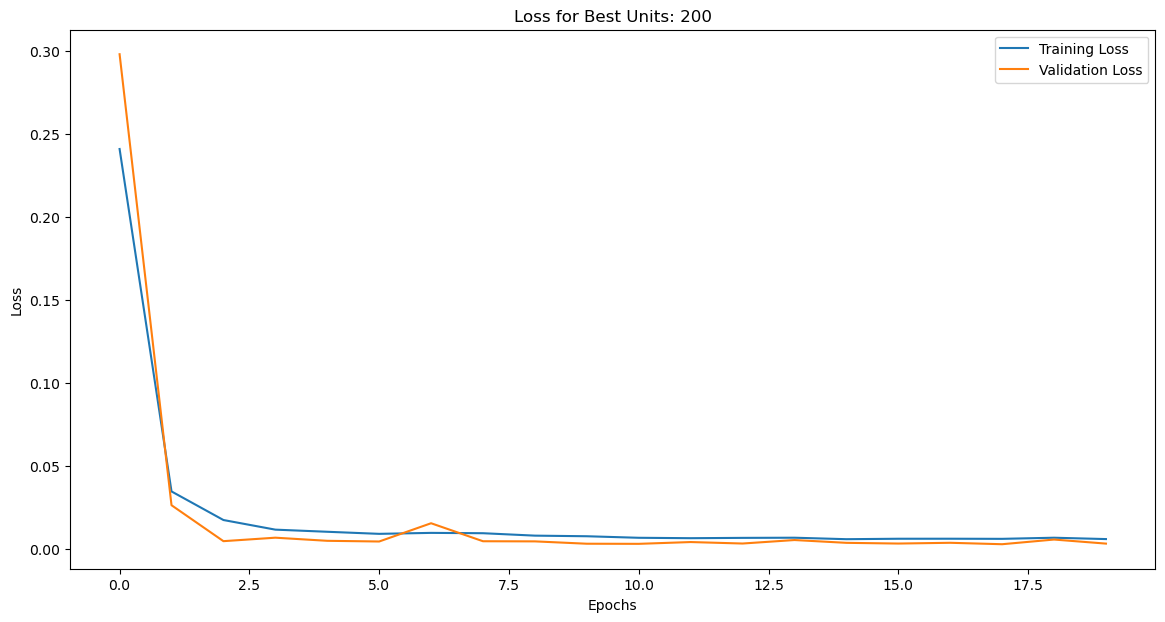

In [23]:
# Plot the training and validation loss for each number of units
plt.figure(figsize=(14, 7))
for units, history in unit_histories.items():
    plt.plot(history.history['val_loss'], label=f'{units} Units Validation Loss')

plt.title('Validation Loss for Different Numbers of Units')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Find the best model based on the lowest MSE in units search
best_unit_model = unit_results_df.loc[unit_results_df['mse'].idxmin()]

print(f"Best Model: Units - {best_unit_model['units']}")
print(f"Mean Squared Error: {best_unit_model['mse']}")
print(f"Mean Absolute Error: {best_unit_model['mae']}")
print(f"R2 Score: {best_unit_model['r2']}")

# Plot training and validation loss for the best units model
best_units = best_unit_model['units']
best_unit_history = unit_histories[best_units]

plt.figure(figsize=(14, 7))
plt.plot(best_unit_history.history['loss'], label='Training Loss')
plt.plot(best_unit_history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss for Best Units: {best_units}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Finding the optimal number of epochs

Training with 10 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
Training with 10 epochs completed.
Training with 20 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Training with 20 epochs completed.
Training with 30 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Training with 30 epochs completed.
Training with 40 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Training with 40 epochs completed.
Training with 50 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Training with 50 epochs completed.
Training with 60 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step
Training with 60 epochs completed.
Training with 70 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Training with 70 epochs completed.
Training with 80 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
Training with 80 epochs completed.
Training with 90 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Training with 90 epochs completed.
Training with 100 epochs...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Training with

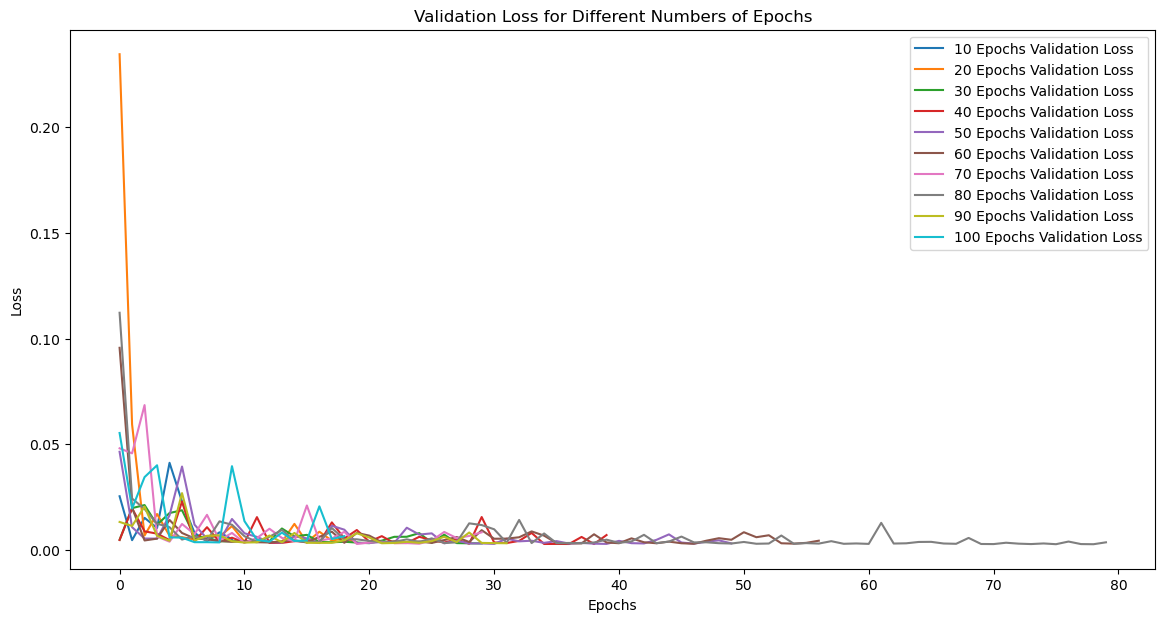

Best Model: Epochs - 70
Mean Squared Error: 5343365.860794302
Mean Absolute Error: 1261.2701567470838
R2 Score: 0.9388483710328868


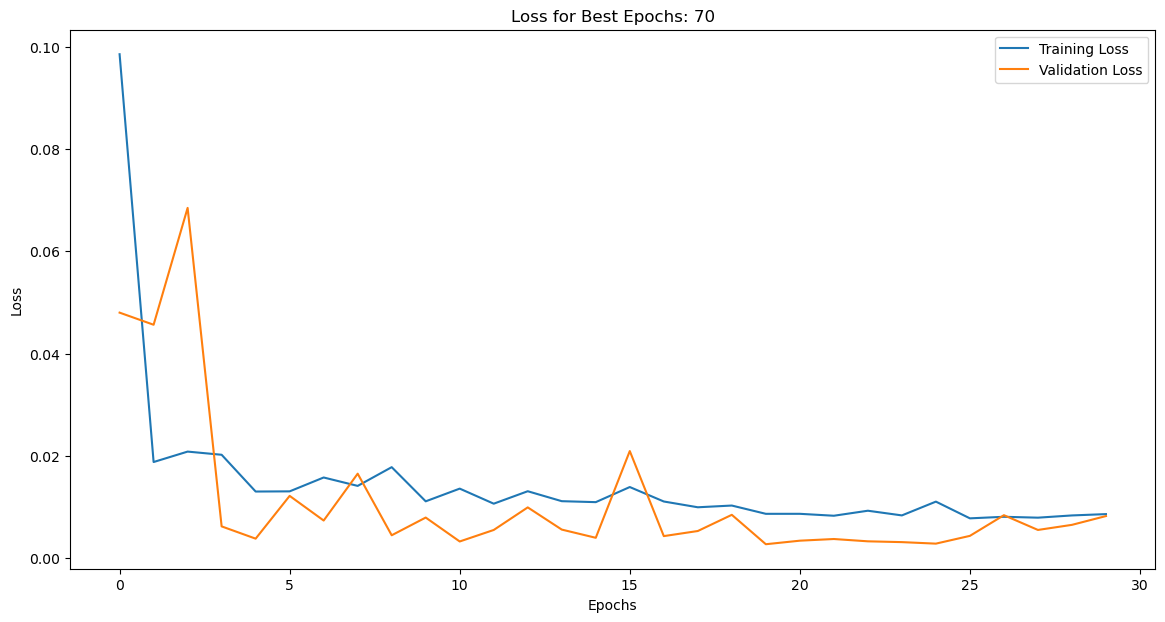

In [24]:
# Function to train the model with different epochs
def train_with_epochs(epochs, units, optimizer_class, loss_fn):
    model = build_model(units)
    optimizer = optimizer_class()  # Create a new optimizer instance
    model.compile(optimizer=optimizer, loss=loss_fn)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2,
                        callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    y_pred = model.predict(x_test)
    y_pred_inverse = scaler.inverse_transform(y_pred)
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    
    return {
        'epochs': epochs,
        'history': history,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }

# Define the range of epochs
epochs_range = range(10, 101, 10)

# Dictionary to store the results for epochs search
epoch_results = []
epoch_histories = {}

# Define best optimizer and loss function from previous phase
best_optimizer_class = Adam  # replace with your best optimizer class
best_loss_function = 'mean_squared_error'  # replace with your best loss function
best_units = 100  # replace with your best units

# Train and evaluate models with each number of epochs
for epochs in epochs_range:
    print(f"Training with {epochs} epochs...")
    result = train_with_epochs(epochs, best_units, best_optimizer_class, best_loss_function)
    epoch_results.append(result)
    epoch_histories[epochs] = result['history']
    print(f"Training with {epochs} epochs completed.")

# Convert results to DataFrame for easy comparison
epoch_results_df = pd.DataFrame(epoch_results)

# Display the results
print(epoch_results_df)

# Plot the training and validation loss for each number of epochs
plt.figure(figsize=(14, 7))
for epochs, history in epoch_histories.items():
    plt.plot(history.history['val_loss'], label=f'{epochs} Epochs Validation Loss')

plt.title('Validation Loss for Different Numbers of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Find the best model based on the lowest MSE in epochs search
best_epoch_model = epoch_results_df.loc[epoch_results_df['mse'].idxmin()]

print(f"Best Model: Epochs - {best_epoch_model['epochs']}")
print(f"Mean Squared Error: {best_epoch_model['mse']}")
print(f"Mean Absolute Error: {best_epoch_model['mae']}")
print(f"R2 Score: {best_epoch_model['r2']}")

# Plot training and validation loss for the best epoch model
best_epochs = best_epoch_model['epochs']
best_epoch_history = epoch_histories[best_epochs]

plt.figure(figsize=(14, 7))
plt.plot(best_epoch_history.history['loss'], label='Training Loss')
plt.plot(best_epoch_history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss for Best Epochs: {best_epochs}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Final features

Best Model: Epochs - 70
Mean Squared Error: 5343365.860794302
Mean Absolute Error: 1261.2701567470838
R2 Score: 0.9388483710328868
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Final Model: Optimizer - <class 'keras.src.optimizers.adam.Adam'>, Loss Function - mean_squared_error, Units - 100, Epochs - 70
Final R2 Score: 0.9310132555319113


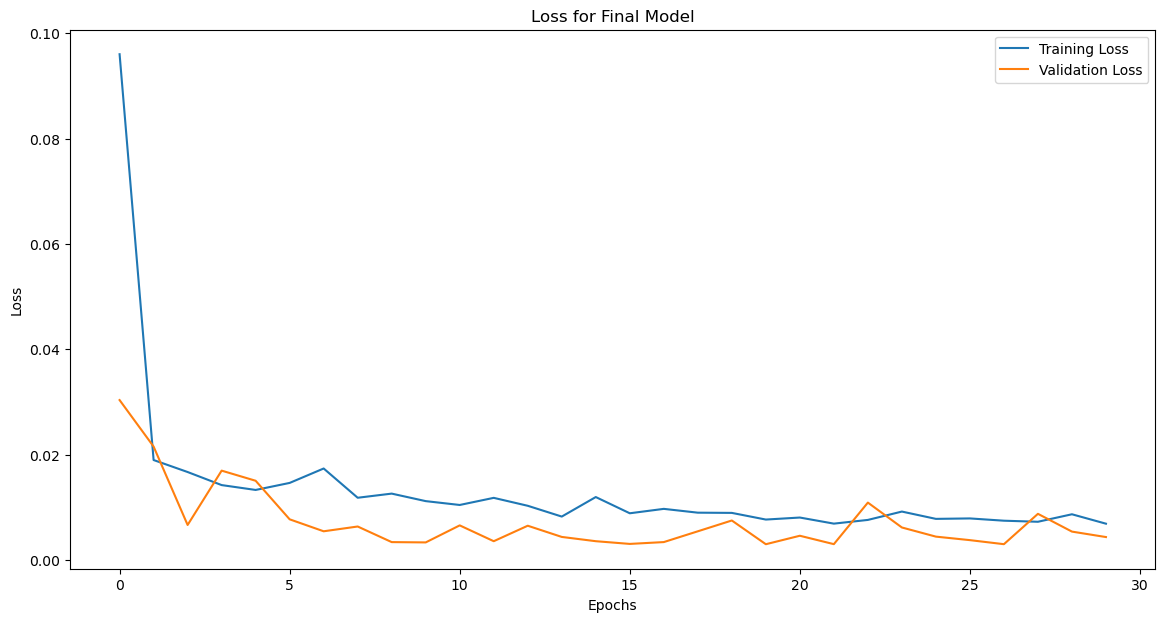

In [31]:
import tensorflow as tf

# Find the best model based on the lowest MSE in epochs search
best_epoch_model = epoch_results_df.loc[epoch_results_df['mse'].idxmin()]

print(f"Best Model: Epochs - {best_epoch_model['epochs']}")
print(f"Mean Squared Error: {best_epoch_model['mse']}")
print(f"Mean Absolute Error: {best_epoch_model['mae']}")
print(f"R2 Score: {best_epoch_model['r2']}")

# Save the best model
final_model = build_model(best_units)
final_model.compile(optimizer=best_optimizer_class(), loss=best_loss_function)

# Train the final model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
final_history = final_model.fit(x_train, y_train, epochs=best_epoch_model['epochs'], batch_size=32, validation_split=0.2,
                                callbacks=[early_stopping], verbose=0)

# Save the model architecture to JSON
model_json = final_model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to H5
final_model.save_weights("model_weights.weights.h5")

# Evaluate the final model
y_pred = final_model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate final R2 score
final_r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f"Final Model: Optimizer - {best_optimizer_class}, Loss Function - {best_loss_function}, Units - {best_units}, Epochs - {best_epoch_model['epochs']}")
print(f"Final R2 Score: {final_r2}")

# Plot training and validation loss for the final model
plt.figure(figsize=(14, 7))
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss for Final Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
